In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
import numpy as np # For array operations
import matplotlib.pyplot as plt
import pickle
from random import shuffle
import random
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path
import cv2 as cv

In [ ]:
!pip install unzip
!unzip "/content/drive/MyDrive/archive.zip"

In [6]:
dataset_path = Path('/content/chest_xray')
train_path = dataset_path / 'train'
test_path = dataset_path / 'test'
val_path = dataset_path / 'val'

In [17]:
print(f'Training Normal Samples: {len(os.listdir(train_path / "NORMAL"))}')
print(f'Training Pneumonia Samples: {len(os.listdir(train_path / "PNEUMONIA"))}')
print('---------------------------------')
print(f'Testing Normal Samples: {len(os.listdir(test_path / "NORMAL"))}')
print(f'Testing Pneumonia Samples: {len(os.listdir(test_path / "PNEUMONIA"))}')
print('---------------------------------')
print(f'Validation Normal Samples: {len(os.listdir(val_path / "NORMAL"))}')
print(f'Validation Pneumonia Samples: {len(os.listdir(val_path / "PNEUMONIA"))}')

Training Normal Samples: 1341
Training Pneumonia Samples: 3875
---------------------------------
Testing Normal Samples: 234
Testing Pneumonia Samples: 390
---------------------------------
Validation Normal Samples: 8
Validation Pneumonia Samples: 8


In [67]:
classes = ['NORMAL', 'PNEUMONIA']
img_width = 32
img_height = 32
seed = 42
random.seed(seed)

def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float') / 255.0
    y = np.asarray(y).astype('float32').reshape((-1, 1))
    return X, y

def get_data(data_dir, classes, img_width, img_height, samples_to_retreive):
    data = []
    for a_class in classes:
      num_of_images = 0
      path = os.path.join(data_dir, a_class)
      class_num = classes.index(a_class)

      for image in os.listdir(path):
        if num_of_images == samples_to_retreive: break
        img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
        resized_img_array = resize_image(img_array, img_width, img_height)
        data.append([resized_img_array, class_num])
        num_of_images += 1
               
    return data

In [46]:
from sklearn.model_selection import train_test_split

training_data = get_data(train_path, classes, img_width, img_height, 600)
random.shuffle(training_data)
X_train, y_train = sep_features_labels(training_data)
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=0.5)

Data Samples: (600, 32, 32, 1)


In [47]:
print(f'Training Samples: {X_train.shape}')
print(f'Validation Samples: {X_val.shape}')

Training Samples: (600, 32, 32, 1)
Validation Samples: (600, 32, 32, 1)


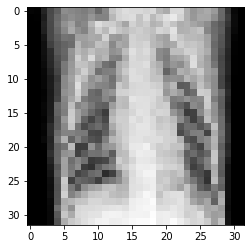

In [66]:
sp_class = 'PNEUMONIA'
index = random.randint(0, len(os.listdir(train_path / sp_class)))
img = cv.imread(os.path.join((train_path / sp_class), os.listdir(train_path / sp_class)[index]), cv.IMREAD_GRAYSCALE) 
img = resize_image(img, img_width, img_height)

plt.imshow(img, cmap='gray')
plt.show()

In [68]:
test_data = get_data(test_path, classes, img_width, img_height, -1)
random.shuffle(test_data)
X_test, y_test = sep_features_labels(test_data)
X_test, y_test = reshape(X_train, y_train, img_width, img_height)
print(f'Test Samples: {X_test.shape}')

Test Samples: (600, 32, 32, 1)


In [69]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(32, 32, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 30, 30, 16)        160       
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                 

In [70]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=132, verbose=1)

Epoch 1/50
5/5 [==============================] - 10s 109ms/step - loss: 0.6829 - accuracy: 0.5767 - val_loss: 0.7389 - val_accuracy: 0.4800
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6647 - accuracy: 0.6367 - val_loss: 0.6340 - val_accuracy: 0.6667
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6095 - accuracy: 0.7100 - val_loss: 0.5389 - val_accuracy: 0.7567
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 0.5316 - accuracy: 0.7533 - val_loss: 0.6047 - val_accuracy: 0.6283
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5350 - accuracy: 0.7033 - val_loss: 0.4308 - val_accuracy: 0.8150
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4307 - accuracy: 0.8233 - val_loss: 0.3572 - val_accuracy: 0.8650
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3800 - accuracy: 0.8350 - val_loss: 0.3157 - val_accuracy: 0.8633
Epoch 8/50
5/5 [=========

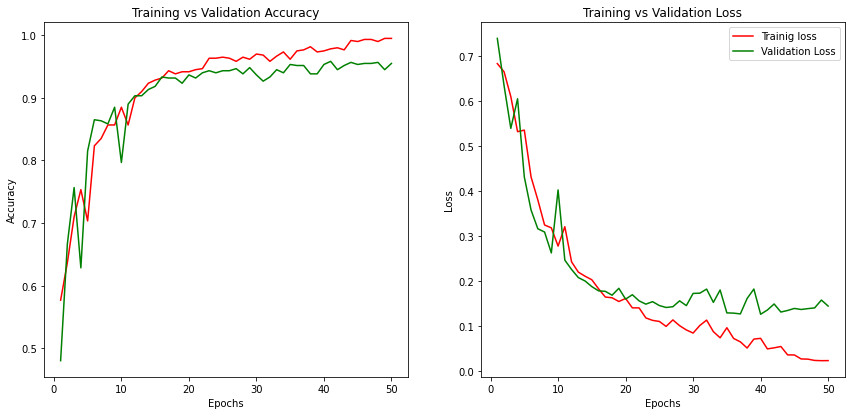

In [81]:
plt.figure(figsize=(30, 30))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.subplot(4, 4, 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(4, 4, 2)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# It seems that the overfitting seems to occur right around the 38th epoch.

In [84]:
# Let us train the model for 38 epochs
model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(32, 32, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=38, batch_size=132, verbose=1)

Epoch 1/38
5/5 [==============================] - 1s 54ms/step - loss: 0.6806 - accuracy: 0.5250 - val_loss: 0.6610 - val_accuracy: 0.4800
Epoch 2/38
5/5 [==============================] - 0s 30ms/step - loss: 0.6269 - accuracy: 0.6533 - val_loss: 0.5675 - val_accuracy: 0.6583
Epoch 3/38
5/5 [==============================] - 0s 33ms/step - loss: 0.5131 - accuracy: 0.7867 - val_loss: 0.4315 - val_accuracy: 0.8283
Epoch 4/38
5/5 [==============================] - 0s 30ms/step - loss: 0.5012 - accuracy: 0.7617 - val_loss: 0.4586 - val_accuracy: 0.7767
Epoch 5/38
5/5 [==============================] - 0s 20ms/step - loss: 0.4458 - accuracy: 0.8017 - val_loss: 0.3854 - val_accuracy: 0.8450
Epoch 6/38
5/5 [==============================] - 0s 20ms/step - loss: 0.4239 - accuracy: 0.8067 - val_loss: 0.3733 - val_accuracy: 0.8467
Epoch 7/38
5/5 [==============================] - 0s 19ms/step - loss: 0.3547 - accuracy: 0.8567 - val_loss: 0.3380 - val_accuracy: 0.8617
Epoch 8/38
5/5 [===========

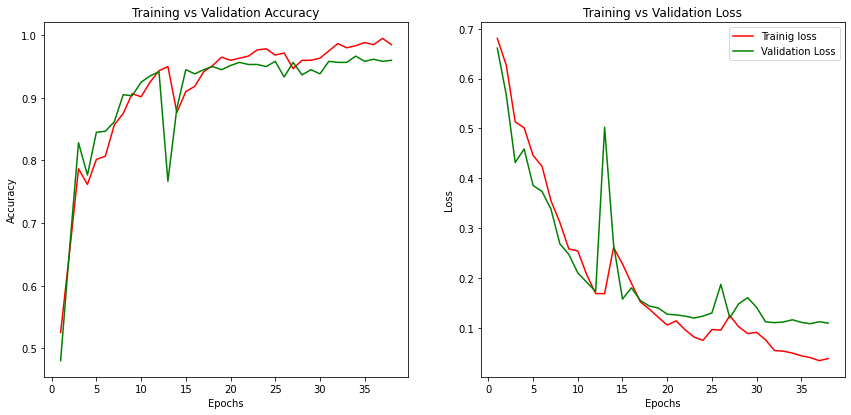

In [85]:
plt.figure(figsize=(30, 30))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.subplot(4, 4, 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(4, 4, 2)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
# Evaluating the model on the test data:
loss, acc = model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 2.1654 - accuracy: 0.4800


In [96]:
acc = round(acc, 2)
print(f'Test Accuracy: {(acc * 100)}%')

Test Accuracy: 48.0%
